# **U-Net 모델 구현**

✅ 아래 코드는 PyTorch로 작성한 간단한 U-Net 모델입니다.

✅ 주요 목표: 작은 이미지 세트로 segmentation 학습을 테스트하기!

✅ 특징: 업샘플링(deconv/upsample 선택 가능), 입력 스케일링, Gaussian noise 추가, 배치 정규화 적용

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# --- 작은 U-Net 정의 ---
class UNetSmall(nn.Module):
    def __init__(self, upsample_mode='deconv', net_scaling=None, edge_crop=0, gaussian_noise_std=0.1):
        super().__init__()
        self.net_scaling = net_scaling
        self.edge_crop = edge_crop
        self.gaussian_noise_std = gaussian_noise_std
        self.upsample_mode = upsample_mode

        # Convolution Block: Conv -> ReLU -> Conv -> ReLU
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True)
            )

        # 인코더 부분 (3 → 16 → 32 → 64 → 128)
        self.enc1 = conv_block(3, 16)
        self.enc2 = conv_block(16, 32)
        self.enc3 = conv_block(32, 64)
        self.enc4 = conv_block(64, 128)
        # Bottleneck
        self.center = conv_block(128, 128)
        self.pool = nn.MaxPool2d(2, stride=2, ceil_mode=True)


        # 업샘플링 부분 정의 (deconv 또는 upsample+conv)
        if upsample_mode == 'deconv':
            def upsample_layer(in_c, out_c):
                # kernel_size=2 로 stride=2를 암묵적으로 쓰고 싶다면 추가 인자를 줘도 됩니다.
                return nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2)
        else:
            def upsample_layer(in_c, out_c):
                return nn.Sequential(
                nn.Upsample(scale_factor=2, mode='nearest'),
                nn.Conv2d(in_c, out_c, kernel_size=1)
    )

        # 디코더 부분
        self.up4 = upsample_layer(128, 64)
        self.dec4 = conv_block(64 + 128, 64)
        self.up3 = upsample_layer(64, 32)
        self.dec3 = conv_block(32 + 64, 32)
        self.up2 = upsample_layer(32, 16)
        self.dec2 = conv_block(16 + 32, 16)
        self.up1 = upsample_layer(16, 16)
        self.dec1 = conv_block(16 + 16, 16)

        # 최종 출력: 1채널(segmentation mask)
        self.final = nn.Conv2d(16, 1, 1)

    def forward(self, x):
        if self.net_scaling:
            # 입력 스케일링
            x = F.avg_pool2d(x, self.net_scaling)
        # Gaussian noise 추가
        if self.gaussian_noise_std:
            noise = torch.randn_like(x) * self.gaussian_noise_std
            x = x + noise

        # 배치 정규화 적용
        x = F.batch_norm(x, running_mean=None, running_var=None, training=True)

        # 인코더
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        # Bottleneck
        center = self.center(self.pool(e4))

        # 디코더 + Skip Connection
        d4 = self.up4(center)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        out = self.final(d1)
        out = torch.sigmoid(out)

        # Crop + Pad
        if self.edge_crop > 0:
            out = out[:, :, self.edge_crop:-self.edge_crop, self.edge_crop:-self.edge_crop]
            out = F.pad(out, (self.edge_crop, self.edge_crop, self.edge_crop, self.edge_crop))
        # Upsample 다시 확대
        if self.net_scaling:
            out = F.interpolate(out, scale_factor=self.net_scaling, mode='nearest')

        return out

## **학습용 데이터 생성하기**

In [10]:
batch_size = 32
x = torch.randn(batch_size, 3, 128, 128)  # RGB 이미지
y = (torch.rand(batch_size, 1, 128, 128) > 0.5).float()  # 랜덤 이진 마스크

dataset = TensorDataset(x, y)
loader = DataLoader(dataset, batch_size=2, shuffle=True)

## **데이터 시각화**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.4259553..3.9290218].


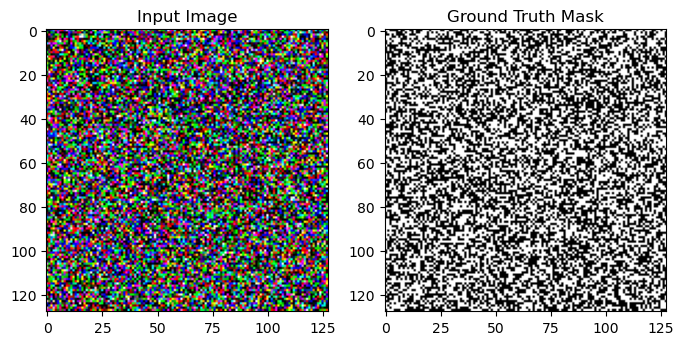

In [11]:
import matplotlib.pyplot as plt
# 첫 번째 이미지를 시각화
sample_x = x[0]
sample_y = y[0]

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample_x.permute(1, 2, 0).numpy())
plt.title('Input Image')

plt.subplot(1, 2, 2)
plt.imshow(sample_y.squeeze().numpy(), cmap='gray')
plt.title('Ground Truth Mask')
plt.show()

## **모델 선언 및 학습**

In [12]:
# --- 모델 선언 및 학습 ---
model = UNetSmall(upsample_mode='deconv', net_scaling=None, edge_crop=0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

# 간단히 30 epoch만
for epoch in range(10):
    model.train()
    total_loss = 0
    for xb, yb in loader:
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(loader):.4f}")

Epoch 1, Loss: 0.6932
Epoch 2, Loss: 0.6931
Epoch 3, Loss: 0.6931
Epoch 4, Loss: 0.6931
Epoch 5, Loss: 0.6930
Epoch 6, Loss: 0.6930
Epoch 7, Loss: 0.6929
Epoch 8, Loss: 0.6928
Epoch 9, Loss: 0.6927
Epoch 10, Loss: 0.6925


## **아래 주석을 풀고 U-Net 모델에 대해 간단히 설명해주세요 😀**

[답변]


--- U-Net은 U자 형태의 인코더–디코더 구조로, 이미지의 다양한 해상도 특징을 추출한 뒤 스킵 커넥션으로 연결하여 정밀한 픽셀 단위 분할을 수행함.



## **아래 주석을 풀고 DeepLabv1, v2, v3. v3+  모델에 대해 각각 간단히 설명해주세요 🐶**

[답변]


---

[DeepLab v1]
- Atrous convolution을 분류 네트워크의 마지막에 적용해 해상도를 유지하며, 출력 후 Dense CRF를 이용해 경계 영역을 보정


[DeepLab v2]
- Atrous Spatial Pyramid Pooling(ASPP)을 도입해 서로 다른 비율의 atrous convolution을 병렬로 사용함으로써 다중 스케일 문맥 정보를 효과적으로 캡처함

[DeepLab v3]
- ASPP에 이미지 수준의 특징 풀링을 추가하고, BatchNorm을 전면에 배치해 성능을 높이며 CRF 없이도 우수한 분할 품질을 달성함

[DeepLab v3+]
- 디코더 모듈을 추가해 encoder의 고해상도 특징과 결합함으로써 더욱 선명한 객체 경계를 복원, 세그멘테이션 결과를 개선